# Conditional Variational Auto Encoder

In [25]:
from keras.layers import Lambda, Input, Dense
from keras.layers import Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate
from keras.models import Model
from keras import metrics
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [46]:
# hyper parameters
input_shape = (28, 28, 1)
num_classes = 10
intermediate_dim = 300
latent_dim = 50
epochs = 200
batch_size = 128
labeled_num = 100
unlabeled_num = 60000 - 100
steps_per_epoch = unlabeled_num // batch_size + 1

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [28]:
# layersリストの中にさらにリストがあっても、ネットワークがつながる。
def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [29]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [30]:
#########
# Input layer
#########
x_in = Input(shape=input_shape, name='input')
y_in = Input(shape=(num_classes,), name='label_input')


########
# encoder
########
x = Flatten()(x_in)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(x_in, [z_mean, z_log_var, z], name='encoder')

########
# classifier
########
classifier_layers = [
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
]
y_output = inst_layers(classifier_layers, x_in)
classifier = Model(x_in, y_output, name='classifier')

########
# decoder
########
decoder_layers = [
    Dense(intermediate_dim, activation='relu'),
    Dense(7*7*32, activation='relu'),
    Reshape((7, 7, 32)),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2DTranspose(filters=1, kernel_size=1, strides=1, activation='sigmoid', padding='same'),
]
# labeled decoder
merged = concatenate([y_in, z])
x_out = inst_layers(decoder_layers, merged)
# Unlabeled decoder
u_merged = concatenate([y_output, z])
u_x_out = inst_layers(decoder_layers, u_merged)

## Loss function

In [31]:
def kl_loss(x, x_decoded_mean, z_mean=z_mean, z_log_var=z_log_var):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logxy_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = np.prod(input_shape) * metrics.binary_crossentropy(x, x_decoded_mean)
   
    # p(y) for observed data is equally distributed
    logy = np.log(1. / num_classes)
    
    return xent_loss - logy

def labeled_vae_loss(x, x_decoded_mean):
    return logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

def cls_loss(y, y_pred, N=1000):
    alpha = 0.1 * N
    return alpha * metrics.categorical_crossentropy(y, y_pred)

def unlabeled_vae_loss(x, x_decoded_mean):
    entropy = metrics.categorical_crossentropy(y_output, y_output)
    labeled_loss = logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    
    return K.mean(K.sum(y_output * labeled_loss, axis=-1)) + entropy

In [32]:
# instantiate C-VAE model
# x_out = decoder([y_in, encoder(encoder_input)[2]])
labeled_vae = Model([x_in, y_in], [x_out, y_output], name='label_c_vae')
unlabeled_vae = Model(x_in, u_x_out, name='unlabel_c_vae')

labeled_vae.compile(optimizer='adam', loss=[labeled_vae_loss, cls_loss])
unlabeled_vae.compile(optimizer='adam', loss=[unlabeled_vae_loss])

In [33]:
plot_model(labeled_vae, to_file='label_c_vae_model.png', show_shapes=True)
plot_model(unlabeled_vae, to_file='unlabel_c_vae_model.png', show_shapes=True)

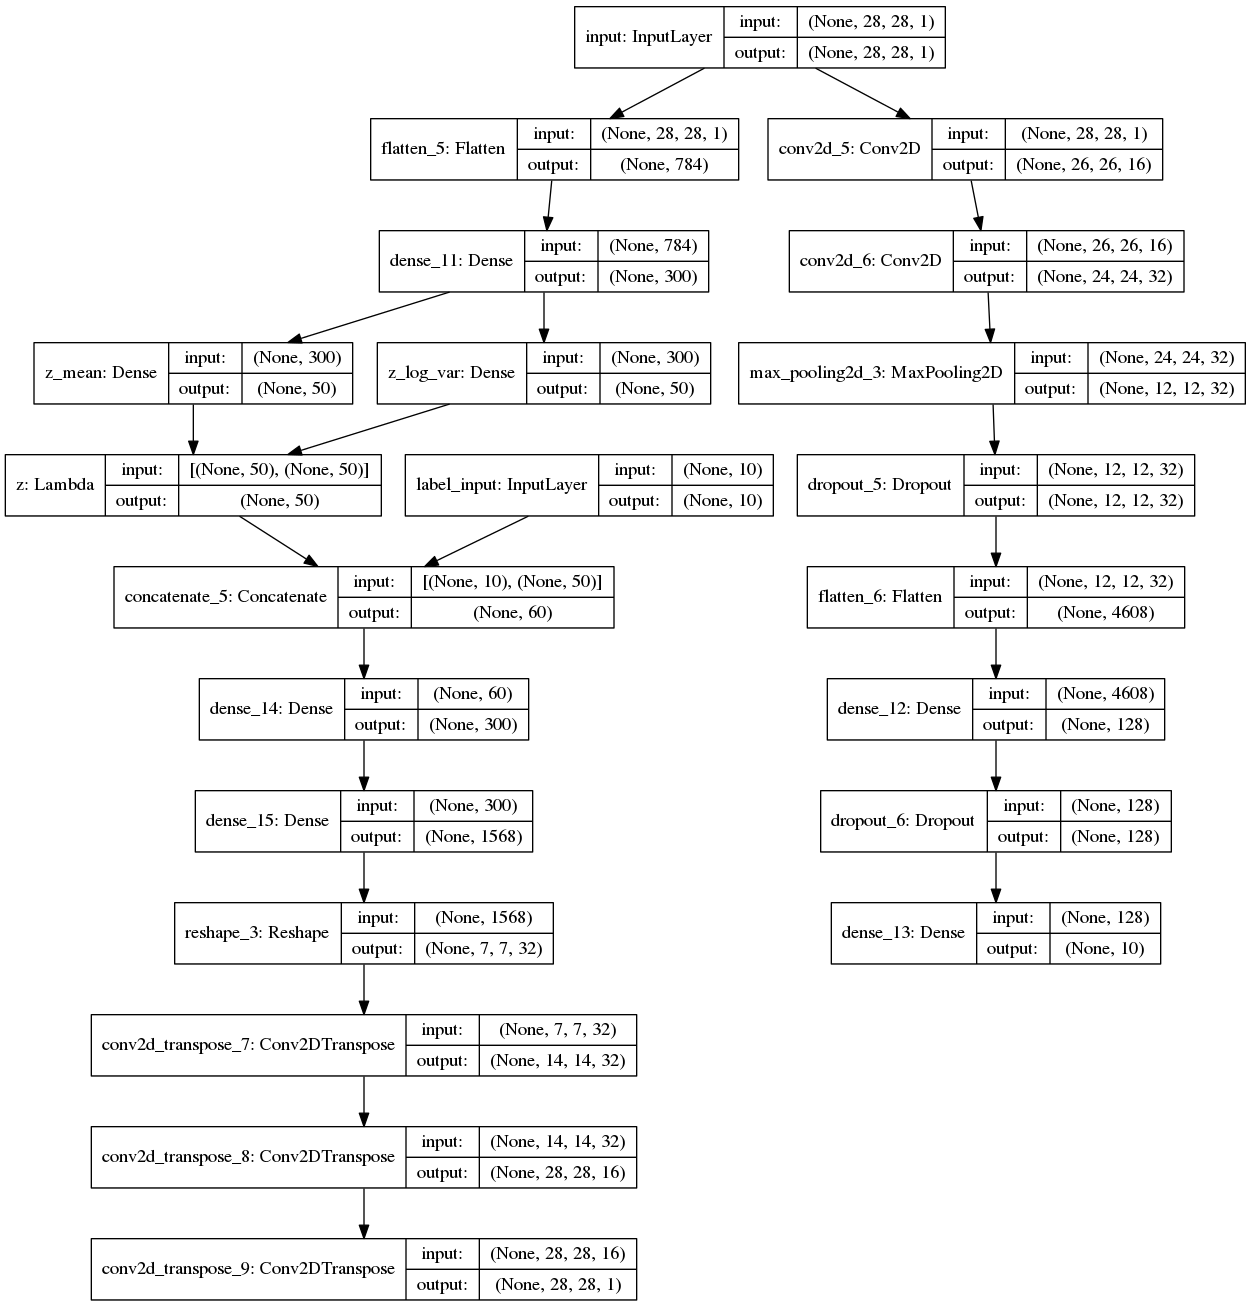

In [34]:
from keras.preprocessing.image import load_img
load_img('label_c_vae_model.png')

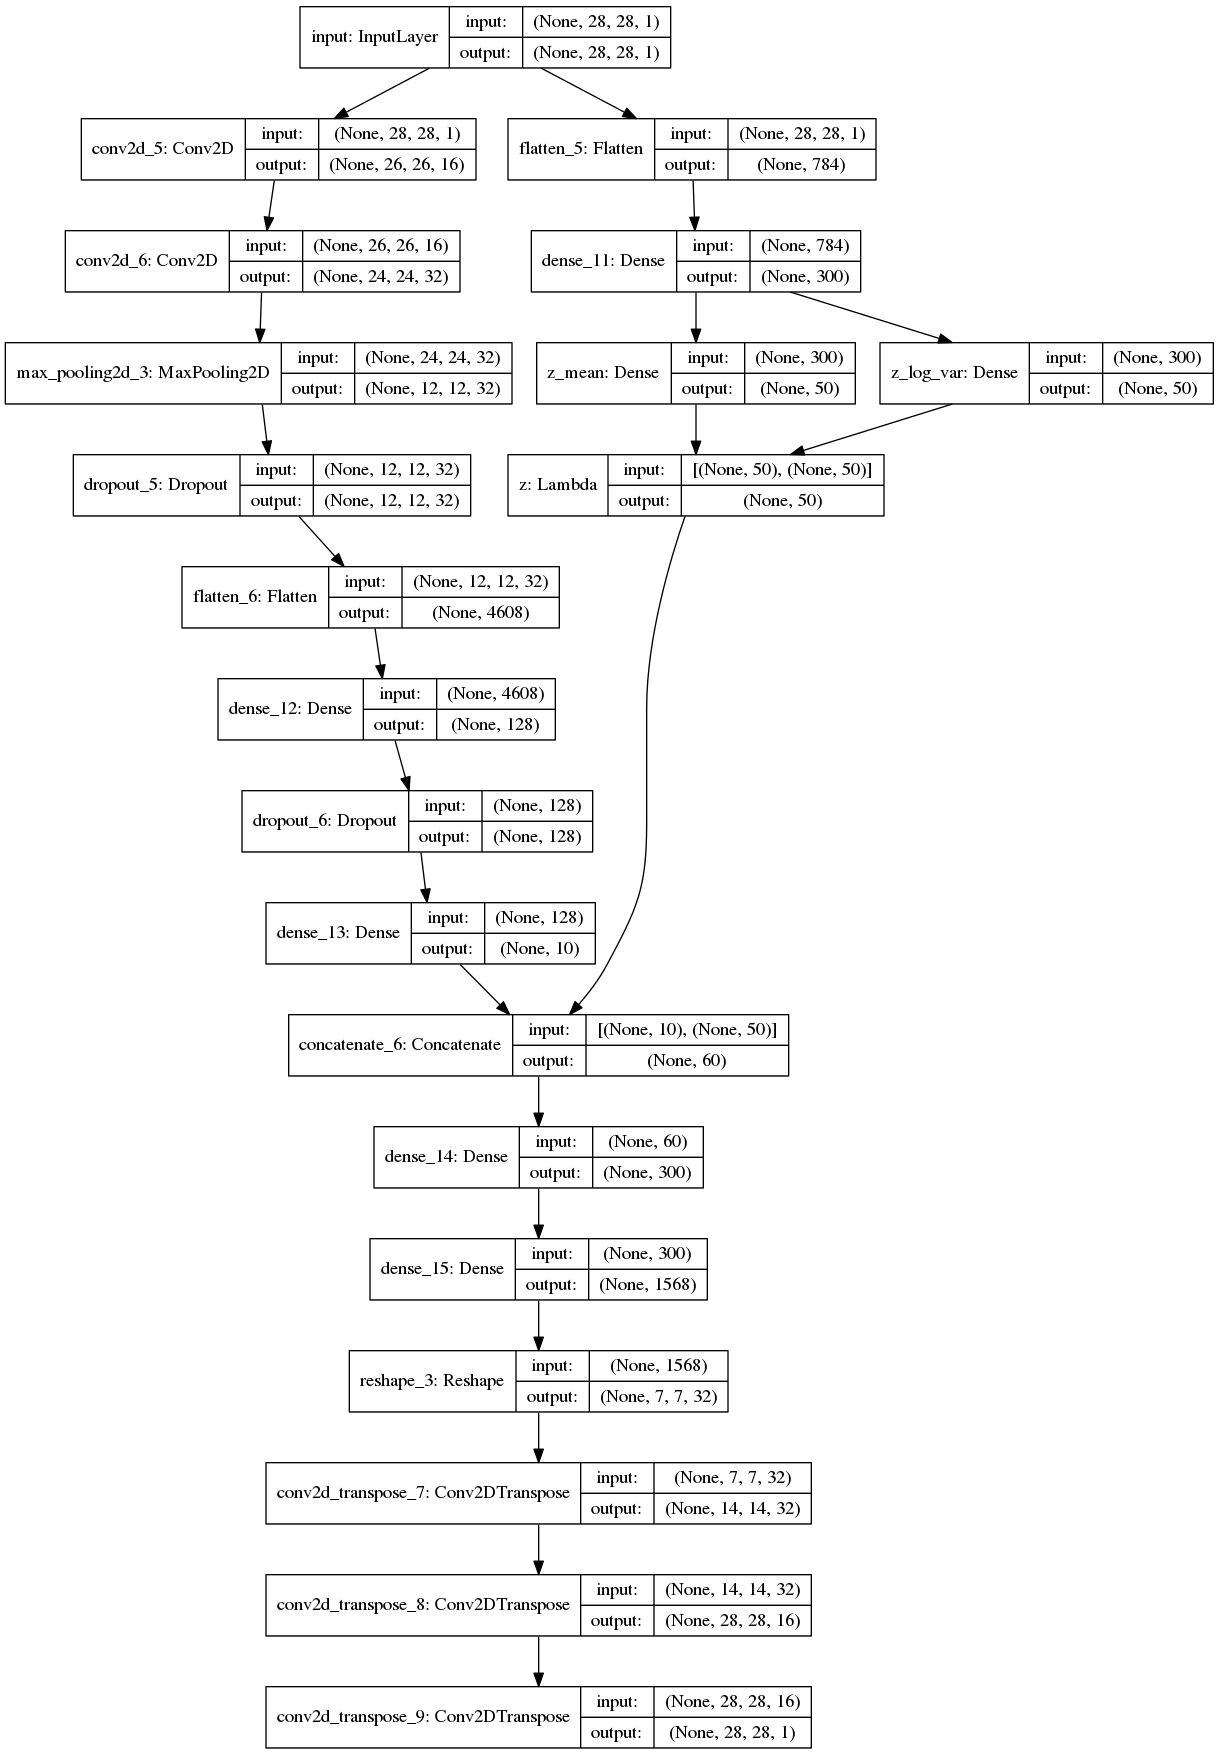

In [35]:
load_img('unlabel_c_vae_model.png')

## prepare training data (labeled / unlabeled)

In [36]:
num_samples = 10
x_labeled = []
y_labeled = []
x_unlabeled = []

for class_index in range(10):
    label_index = np.where(y_train == class_index)
    class_input_data = x_train[label_index]
    
    # labeled data
    x_labeled.append(class_input_data[:num_samples])
    y_labeled.append(np.full(num_samples, class_index, int))
    
    # unlabeled data
    x_unlabeled.append(class_input_data[num_samples:])
    
x_labeled = np.concatenate(x_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
x_labeled = x_labeled.astype('float32') / 255
x_unlabeled = x_unlabeled.astype('float32') / 255

x_labeled = x_labeled.reshape(x_labeled.shape+(1,))
x_unlabeled = x_unlabeled.reshape(x_unlabeled.shape+(1,))

y_labeled = np.concatenate(y_labeled, axis=0)
y_labeled_onehot = np.eye(num_classes)[y_labeled]


# test data
x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(x_test.shape+(1,))
y_test = np.eye(num_classes)[y_test]

In [37]:
print('labeled input_shape: {}, {}\nunlabeled input_shape: {}'.format(x_labeled.shape, y_labeled_onehot.shape, x_unlabeled.shape))
print('test input_shape: ', x_test.shape, y_test.shape)

labeled input_shape: (100, 28, 28, 1), (100, 10)
unlabeled input_shape: (59900, 28, 28, 1)
test input_shape:  (10000, 28, 28, 1) (10000, 10)


## まずは少量の教師あり(10ショット)学習

In [38]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               589952    
__________

In [39]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
history = classifier.fit(x_labeled, y_labeled_onehot, epochs=1000, batch_size=batch_size, validation_data=(x_test, y_test))

Train on 100 samples, validate on 10000 samples
Epoch 1/1000
100/100 [==============================] - 0s 2ms/step - loss: 2.6170 - acc: 0.1000 - val_loss: 2.5805 - val_acc: 0.0958
Epoch 2/1000
100/100 [==============================] - 0s 2ms/step - loss: 2.5712 - acc: 0.1000 - val_loss: 2.5475 - val_acc: 0.1009
Epoch 3/1000
100/100 [==============================] - 0s 3ms/step - loss: 2.5476 - acc: 0.1000 - val_loss: 2.5231 - val_acc: 0.1009
Epoch 4/1000
100/100 [==============================] - 0s 2ms/step - loss: 2.5196 - acc: 0.0700 - val_loss: 2.4984 - val_acc: 0.1009
Epoch 5/1000
100/100 [==============================] - 0s 2ms/step - loss: 2.5009 - acc: 0.1300 - val_loss: 2.4719 - val_acc: 0.1155
Epoch 6/1000
100/100 [==============================] - 0s 3ms/step - loss: 2.4897 - acc: 0.1500 - val_loss: 2.4480 - val_acc: 0.1032
Epoch 7/1000
100/100 [==============================] - 0s 2ms/step - loss: 2.4635 - acc: 0.1100 - val_loss: 2.4267 - val_acc: 0.1032
Epoch 8/1000
1

Epoch 62/1000
100/100 [==============================] - 0s 3ms/step - loss: 1.6374 - acc: 0.4200 - val_loss: 1.6540 - val_acc: 0.5318
Epoch 63/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.5450 - acc: 0.4700 - val_loss: 1.6159 - val_acc: 0.5278
Epoch 64/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.5921 - acc: 0.4300 - val_loss: 1.5775 - val_acc: 0.5433
Epoch 65/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.6089 - acc: 0.3600 - val_loss: 1.5566 - val_acc: 0.5553
Epoch 66/1000
100/100 [==============================] - 0s 3ms/step - loss: 1.6360 - acc: 0.4300 - val_loss: 1.5645 - val_acc: 0.5612
Epoch 67/1000
100/100 [==============================] - 0s 3ms/step - loss: 1.6724 - acc: 0.4200 - val_loss: 1.5959 - val_acc: 0.5583
Epoch 68/1000
100/100 [==============================] - 0s 3ms/step - loss: 1.5868 - acc: 0.4500 - val_loss: 1.6027 - val_acc: 0.5601
Epoch 69/1000
100/100 [==============================] 

Epoch 123/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.3356 - acc: 0.8800 - val_loss: 1.3094 - val_acc: 0.7048
Epoch 124/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.3651 - acc: 0.8800 - val_loss: 1.3289 - val_acc: 0.7034
Epoch 125/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.5703 - acc: 0.8000 - val_loss: 1.3343 - val_acc: 0.7051
Epoch 126/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.3899 - acc: 0.8400 - val_loss: 1.3365 - val_acc: 0.7027
Epoch 127/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.3952 - acc: 0.8500 - val_loss: 1.3332 - val_acc: 0.7051
Epoch 128/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.4093 - acc: 0.8700 - val_loss: 1.3274 - val_acc: 0.7092
Epoch 129/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.3492 - acc: 0.8400 - val_loss: 1.3179 - val_acc: 0.7103
Epoch 130/1000
100/100 [========================

Epoch 184/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1323 - acc: 0.9600 - val_loss: 1.5091 - val_acc: 0.7345
Epoch 185/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.2203 - acc: 0.9200 - val_loss: 1.5190 - val_acc: 0.7338
Epoch 186/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.2118 - acc: 0.9400 - val_loss: 1.5355 - val_acc: 0.7358
Epoch 187/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1600 - acc: 0.9400 - val_loss: 1.5555 - val_acc: 0.7347
Epoch 188/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1645 - acc: 0.9300 - val_loss: 1.5772 - val_acc: 0.7345
Epoch 189/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.2038 - acc: 0.9200 - val_loss: 1.6007 - val_acc: 0.7351
Epoch 190/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1763 - acc: 0.9400 - val_loss: 1.6370 - val_acc: 0.7349
Epoch 191/1000
100/100 [========================

Epoch 245/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0872 - acc: 0.9700 - val_loss: 1.8410 - val_acc: 0.7357
Epoch 246/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1986 - acc: 0.9300 - val_loss: 1.8519 - val_acc: 0.7369
Epoch 247/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0869 - acc: 0.9700 - val_loss: 1.8678 - val_acc: 0.7368
Epoch 248/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1978 - acc: 0.9100 - val_loss: 1.8751 - val_acc: 0.7355
Epoch 249/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1255 - acc: 0.9200 - val_loss: 1.8730 - val_acc: 0.7376
Epoch 250/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0999 - acc: 0.9500 - val_loss: 1.8683 - val_acc: 0.7366
Epoch 251/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1478 - acc: 0.9400 - val_loss: 1.8667 - val_acc: 0.7354
Epoch 252/1000
100/100 [========================

Epoch 306/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1190 - acc: 0.9600 - val_loss: 1.9384 - val_acc: 0.7351
Epoch 307/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0697 - acc: 0.9800 - val_loss: 1.9313 - val_acc: 0.7354
Epoch 308/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1204 - acc: 0.9500 - val_loss: 1.9184 - val_acc: 0.7367
Epoch 309/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0919 - acc: 0.9500 - val_loss: 1.8986 - val_acc: 0.7394
Epoch 310/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0988 - acc: 0.9700 - val_loss: 1.8800 - val_acc: 0.7412
Epoch 311/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0971 - acc: 0.9600 - val_loss: 1.8671 - val_acc: 0.7415
Epoch 312/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0559 - acc: 0.9800 - val_loss: 1.8601 - val_acc: 0.7427
Epoch 313/1000
100/100 [========================

Epoch 367/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0878 - acc: 0.9800 - val_loss: 2.1587 - val_acc: 0.7235
Epoch 368/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0830 - acc: 0.9700 - val_loss: 2.1618 - val_acc: 0.7245
Epoch 369/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0778 - acc: 0.9600 - val_loss: 2.1617 - val_acc: 0.7242
Epoch 370/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0822 - acc: 0.9600 - val_loss: 2.1530 - val_acc: 0.7264
Epoch 371/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0762 - acc: 0.9800 - val_loss: 2.1445 - val_acc: 0.7294
Epoch 372/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0661 - acc: 0.9800 - val_loss: 2.1376 - val_acc: 0.7295
Epoch 373/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0651 - acc: 0.9600 - val_loss: 2.1351 - val_acc: 0.7319
Epoch 374/1000
100/100 [========================

Epoch 428/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0730 - acc: 0.9800 - val_loss: 2.0838 - val_acc: 0.7353
Epoch 429/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0506 - acc: 0.9900 - val_loss: 2.0757 - val_acc: 0.7370
Epoch 430/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0419 - acc: 0.9900 - val_loss: 2.0774 - val_acc: 0.7367
Epoch 431/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0530 - acc: 0.9800 - val_loss: 2.0804 - val_acc: 0.7369
Epoch 432/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0219 - acc: 1.0000 - val_loss: 2.0872 - val_acc: 0.7372
Epoch 433/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0567 - acc: 0.9600 - val_loss: 2.1033 - val_acc: 0.7377
Epoch 434/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0587 - acc: 0.9800 - val_loss: 2.1300 - val_acc: 0.7365
Epoch 435/1000
100/100 [========================

Epoch 489/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0139 - acc: 1.0000 - val_loss: 2.1964 - val_acc: 0.7331
Epoch 490/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.0446 - acc: 0.9900 - val_loss: 2.2230 - val_acc: 0.7307
Epoch 491/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1066 - acc: 0.9500 - val_loss: 2.2301 - val_acc: 0.7312
Epoch 492/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0844 - acc: 0.9500 - val_loss: 2.2479 - val_acc: 0.7286
Epoch 493/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0654 - acc: 0.9700 - val_loss: 2.2522 - val_acc: 0.7280
Epoch 494/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0784 - acc: 0.9600 - val_loss: 2.2539 - val_acc: 0.7282
Epoch 495/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0396 - acc: 0.9800 - val_loss: 2.2520 - val_acc: 0.7277
Epoch 496/1000
100/100 [========================

Epoch 550/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1161 - acc: 0.9600 - val_loss: 2.3242 - val_acc: 0.7337
Epoch 551/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0754 - acc: 0.9700 - val_loss: 2.3251 - val_acc: 0.7319
Epoch 552/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0468 - acc: 0.9900 - val_loss: 2.3337 - val_acc: 0.7305
Epoch 553/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 2.3432 - val_acc: 0.7298
Epoch 554/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0618 - acc: 0.9700 - val_loss: 2.3421 - val_acc: 0.7310
Epoch 555/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0200 - acc: 0.9900 - val_loss: 2.3443 - val_acc: 0.7300
Epoch 556/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0211 - acc: 0.9900 - val_loss: 2.3460 - val_acc: 0.7277
Epoch 557/1000
100/100 [========================

Epoch 611/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0437 - acc: 0.9900 - val_loss: 2.3084 - val_acc: 0.7340
Epoch 612/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0663 - acc: 0.9700 - val_loss: 2.2942 - val_acc: 0.7352
Epoch 613/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0572 - acc: 0.9800 - val_loss: 2.2837 - val_acc: 0.7357
Epoch 614/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0777 - acc: 0.9600 - val_loss: 2.2749 - val_acc: 0.7358
Epoch 615/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0516 - acc: 0.9700 - val_loss: 2.2706 - val_acc: 0.7350
Epoch 616/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0475 - acc: 0.9800 - val_loss: 2.2685 - val_acc: 0.7347
Epoch 617/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0157 - acc: 1.0000 - val_loss: 2.2708 - val_acc: 0.7338
Epoch 618/1000
100/100 [========================

Epoch 672/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0259 - acc: 0.9900 - val_loss: 2.2535 - val_acc: 0.7418
Epoch 673/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0403 - acc: 0.9700 - val_loss: 2.2601 - val_acc: 0.7409
Epoch 674/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0133 - acc: 1.0000 - val_loss: 2.2703 - val_acc: 0.7402
Epoch 675/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0166 - acc: 1.0000 - val_loss: 2.2830 - val_acc: 0.7396
Epoch 676/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0135 - acc: 0.9900 - val_loss: 2.2959 - val_acc: 0.7384
Epoch 677/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0326 - acc: 0.9900 - val_loss: 2.3072 - val_acc: 0.7372
Epoch 678/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0196 - acc: 0.9900 - val_loss: 2.3234 - val_acc: 0.7365
Epoch 679/1000
100/100 [========================

Epoch 733/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0858 - acc: 0.9600 - val_loss: 2.4505 - val_acc: 0.7242
Epoch 734/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0182 - acc: 0.9900 - val_loss: 2.4558 - val_acc: 0.7235
Epoch 735/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0277 - acc: 0.9800 - val_loss: 2.4639 - val_acc: 0.7228
Epoch 736/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0426 - acc: 0.9900 - val_loss: 2.4711 - val_acc: 0.7220
Epoch 737/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0486 - acc: 0.9800 - val_loss: 2.4738 - val_acc: 0.7219
Epoch 738/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0510 - acc: 0.9800 - val_loss: 2.4737 - val_acc: 0.7225
Epoch 739/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0251 - acc: 0.9800 - val_loss: 2.4719 - val_acc: 0.7241
Epoch 740/1000
100/100 [========================

Epoch 794/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0716 - acc: 0.9800 - val_loss: 2.3161 - val_acc: 0.7369
Epoch 795/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0591 - acc: 0.9800 - val_loss: 2.3234 - val_acc: 0.7371
Epoch 796/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0820 - acc: 0.9500 - val_loss: 2.3338 - val_acc: 0.7366
Epoch 797/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.0230 - acc: 0.9900 - val_loss: 2.3467 - val_acc: 0.7359
Epoch 798/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0186 - acc: 0.9900 - val_loss: 2.3591 - val_acc: 0.7359
Epoch 799/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0524 - acc: 0.9900 - val_loss: 2.3831 - val_acc: 0.7344
Epoch 800/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0334 - acc: 0.9900 - val_loss: 2.4134 - val_acc: 0.7317
Epoch 801/1000
100/100 [========================

Epoch 855/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0219 - acc: 0.9900 - val_loss: 2.4513 - val_acc: 0.7353
Epoch 856/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0345 - acc: 0.9900 - val_loss: 2.4541 - val_acc: 0.7346
Epoch 857/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0462 - acc: 0.9800 - val_loss: 2.4629 - val_acc: 0.7342
Epoch 858/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0229 - acc: 0.9900 - val_loss: 2.4787 - val_acc: 0.7330
Epoch 859/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0337 - acc: 0.9900 - val_loss: 2.4939 - val_acc: 0.7335
Epoch 860/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0320 - acc: 0.9900 - val_loss: 2.5103 - val_acc: 0.7326
Epoch 861/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0100 - acc: 1.0000 - val_loss: 2.5238 - val_acc: 0.7320
Epoch 862/1000
100/100 [========================

Epoch 916/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0178 - acc: 1.0000 - val_loss: 2.6831 - val_acc: 0.7314
Epoch 917/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0248 - acc: 1.0000 - val_loss: 2.6917 - val_acc: 0.7303
Epoch 918/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0369 - acc: 0.9800 - val_loss: 2.7011 - val_acc: 0.7287
Epoch 919/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 2.7138 - val_acc: 0.7277
Epoch 920/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0439 - acc: 0.9800 - val_loss: 2.7370 - val_acc: 0.7251
Epoch 921/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0484 - acc: 0.9800 - val_loss: 2.7605 - val_acc: 0.7228
Epoch 922/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0154 - acc: 1.0000 - val_loss: 2.7832 - val_acc: 0.7191
Epoch 923/1000
100/100 [========================

Epoch 977/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0274 - acc: 0.9900 - val_loss: 2.5818 - val_acc: 0.7260
Epoch 978/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0321 - acc: 0.9900 - val_loss: 2.5812 - val_acc: 0.7257
Epoch 979/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0132 - acc: 1.0000 - val_loss: 2.5893 - val_acc: 0.7266
Epoch 980/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0466 - acc: 0.9900 - val_loss: 2.5944 - val_acc: 0.7265
Epoch 981/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0312 - acc: 0.9800 - val_loss: 2.5985 - val_acc: 0.7266
Epoch 982/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1093 - acc: 0.9800 - val_loss: 2.5874 - val_acc: 0.7269
Epoch 983/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0458 - acc: 0.9800 - val_loss: 2.5833 - val_acc: 0.7279
Epoch 984/1000
100/100 [========================

In [68]:
def plot_history(history):
    # 精度の履歴をプロット
    if 'acc' in history.history:
        plt.plot(history.history['acc'], "o-", label="accuracy")
        if 'val_acc' in history.history:
            plt.plot(history.history['val_acc'], "o-", label="validation_accuracy")
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1.05])
        plt.legend(loc="upper left")
        plt.show()

    # 損失の履歴をプロット
    if 'loss' in history.history:
        plt.plot(history.history['loss'],"o-",label="loss",)
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], "o-", label="val_loss")
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='lower right')
        plt.show()

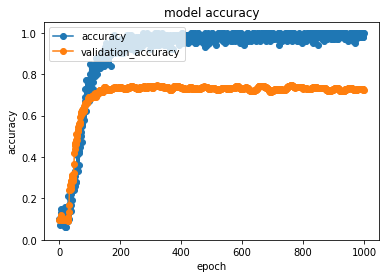

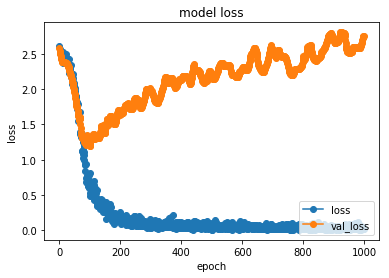

In [69]:
plot_history(history)

In [65]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [66]:
reset_weights(classifier)

## 半教師あり学習(semi-supervised learning)

In [50]:
# 教師なしの枚数が、教師ありと一致するようにリピート
labeled_index = []
for i in range(len(x_unlabeled) // len(x_labeled)):
    l = np.arange(len(x_labeled))
    np.random.shuffle(l)
    labeled_index.append(l)
labeled_index = np.concatenate(labeled_index)

unlabeled_index = np.arange(len(x_unlabeled))

In [51]:
loss, validation_history = [], []
for epoch in range(epochs):
    print('epoch {}/{}'.format(epoch+1, epochs))
    np.random.shuffle(unlabeled_index)
    
    for i in range(steps_per_epoch-1):
        # print('step {}/ {}'.format(i+1, steps_per_epoch-1))
        # Labeled
        index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
        loss += labeled_vae.train_on_batch([x_labeled[index_range], y_labeled_onehot[index_range]], 
                                        [x_labeled[index_range], y_labeled_onehot[index_range]])

        # Unlabeled
        index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
        loss += unlabeled_vae.train_on_batch(x_unlabeled[index_range],  x_unlabeled[index_range])
        
    # final step
        
    # Labeled
    index_range =  labeled_index[(steps_per_epoch-1) * batch_size:]
    loss += labeled_vae.train_on_batch([x_labeled[index_range], y_labeled_onehot[index_range]], 
                                    [x_labeled[index_range], y_labeled_onehot[index_range]])

    # Unlabeled
    index_range =  unlabeled_index[(steps_per_epoch-1) * batch_size:]
    loss += unlabeled_vae.train_on_batch(x_unlabeled[index_range],  x_unlabeled[index_range])
    # validation accuracy
    history = classifier.evaluate(x_test, y_test)
    print(history)
    validation_history.append(history)

epoch 1/200
10000/10000 [==============================] - 1s 80us/step
[0.48650794270038605, 0.84709999999999996]
epoch 2/200
10000/10000 [==============================] - 1s 80us/step
[0.48173467157483102, 0.84960000000000002]
epoch 3/200
10000/10000 [==============================] - 1s 82us/step
[0.46377093563079835, 0.8508]
epoch 4/200
10000/10000 [==============================] - 1s 81us/step
[0.4635000187754631, 0.85909999999999997]
epoch 5/200
10000/10000 [==============================] - 1s 78us/step
[0.43928662001639607, 0.86329999999999996]
epoch 6/200
10000/10000 [==============================] - 1s 81us/step
[0.43834878055900334, 0.86499999999999999]
epoch 7/200
10000/10000 [==============================] - 1s 81us/step
[0.45036194447875022, 0.87690000000000001]
epoch 8/200
10000/10000 [==============================] - 1s 80us/step
[0.44021600965708496, 0.86160000000000003]
epoch 9/200
10000/10000 [==============================] - 1s 78us/step
[0.44954421006143092, 

10000/10000 [==============================] - 1s 83us/step
[0.27706839429046959, 0.92889999999999995]
epoch 73/200
10000/10000 [==============================] - 1s 81us/step
[0.30855650390358641, 0.9234]
epoch 74/200
10000/10000 [==============================] - 1s 77us/step
[0.2736803438410163, 0.93389999999999995]
epoch 75/200
10000/10000 [==============================] - 1s 82us/step
[0.29423185266405344, 0.92579999999999996]
epoch 76/200
10000/10000 [==============================] - 1s 79us/step
[0.29837849399484695, 0.92379999999999995]
epoch 77/200
10000/10000 [==============================] - 1s 79us/step
[0.2941622276203707, 0.92920000000000003]
epoch 78/200
10000/10000 [==============================] - 1s 80us/step
[0.28757973928898573, 0.92659999999999998]
epoch 79/200
10000/10000 [==============================] - 1s 82us/step
[0.29573239655978978, 0.92330000000000001]
epoch 80/200
10000/10000 [==============================] - 1s 81us/step
[0.28394698282554748, 0.933

10000/10000 [==============================] - 1s 81us/step
[0.25821213016132827, 0.93479999999999996]
epoch 144/200
10000/10000 [==============================] - 1s 81us/step
[0.27713528745719229, 0.92789999999999995]
epoch 145/200
10000/10000 [==============================] - 1s 80us/step
[0.29295226817703807, 0.92620000000000002]
epoch 146/200
10000/10000 [==============================] - 1s 80us/step
[0.27174353126220813, 0.9335]
epoch 147/200
10000/10000 [==============================] - 1s 81us/step
[0.27091803968301975, 0.93540000000000001]
epoch 148/200
10000/10000 [==============================] - 1s 80us/step
[0.2834971159876557, 0.93069999999999997]
epoch 149/200
10000/10000 [==============================] - 1s 79us/step
[0.29265135359945704, 0.92649999999999999]
epoch 150/200
10000/10000 [==============================] - 1s 83us/step
[0.29302140458241049, 0.93169999999999997]
epoch 151/200
10000/10000 [==============================] - 1s 79us/step
[0.299026233493362

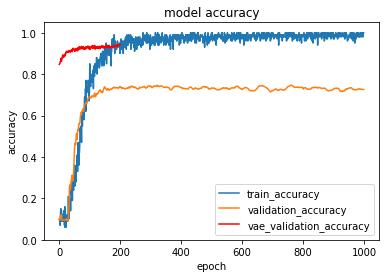

In [86]:
#plt.plot(np.array(validation_history).T[0])


if 'acc' in history.history:
    plt.plot(history.history['acc'], "-", label="train_accuracy", zorder=1)
    if 'val_acc' in history.history:
        plt.plot(history.history['val_acc'], "-", label="validation_accuracy", zorder=2)
plt.plot(np.array(validation_history).T[1], "-",color="red", label="vae_validation_accuracy", zorder=3)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()